In [24]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import urllib.request, json


In [25]:
import sklearn 
from sklearn.preprocessing import MinMaxScaler

In [26]:
df = pd.read_csv(os.path.join('Stocks', 'hpq.us.txt'), delimiter=',', usecols=['Date', 'Open', 'High', 'Low', 'Close'])
print('Loaded Data Successfully')

Loaded Data Successfully


In [27]:
df.head(10)

,Date,Open,High,Low,Close
0,1970-01-02,0.30627,0.30627,0.30627,0.30627
1,1970-01-05,0.30627,0.31768,0.30627,0.31385
2,1970-01-06,0.31385,0.31385,0.30996,0.30996
3,1970-01-07,0.31385,0.31385,0.31385,0.31385
4,1970-01-08,0.31385,0.31768,0.31385,0.31385
5,1970-01-09,0.31385,0.31768,0.31385,0.31768
6,1970-01-12,0.31768,0.32534,0.31768,0.32534
7,1970-01-13,0.32534,0.32916,0.32152,0.32152
8,1970-01-14,0.32152,0.32534,0.31768,0.32152
9,1970-01-15,0.32152,0.32916,0.32152,0.32916


In [28]:
df = df.sort_values('Date')
df.head(10)

,Date,Open,High,Low,Close
0,1970-01-02,0.30627,0.30627,0.30627,0.30627
1,1970-01-05,0.30627,0.31768,0.30627,0.31385
2,1970-01-06,0.31385,0.31385,0.30996,0.30996
3,1970-01-07,0.31385,0.31385,0.31385,0.31385
4,1970-01-08,0.31385,0.31768,0.31385,0.31385
5,1970-01-09,0.31385,0.31768,0.31385,0.31768
6,1970-01-12,0.31768,0.32534,0.31768,0.32534
7,1970-01-13,0.32534,0.32916,0.32152,0.32152
8,1970-01-14,0.32152,0.32534,0.31768,0.32152
9,1970-01-15,0.32152,0.32916,0.32152,0.32916


Text(0, 0.5, 'Mid Price')

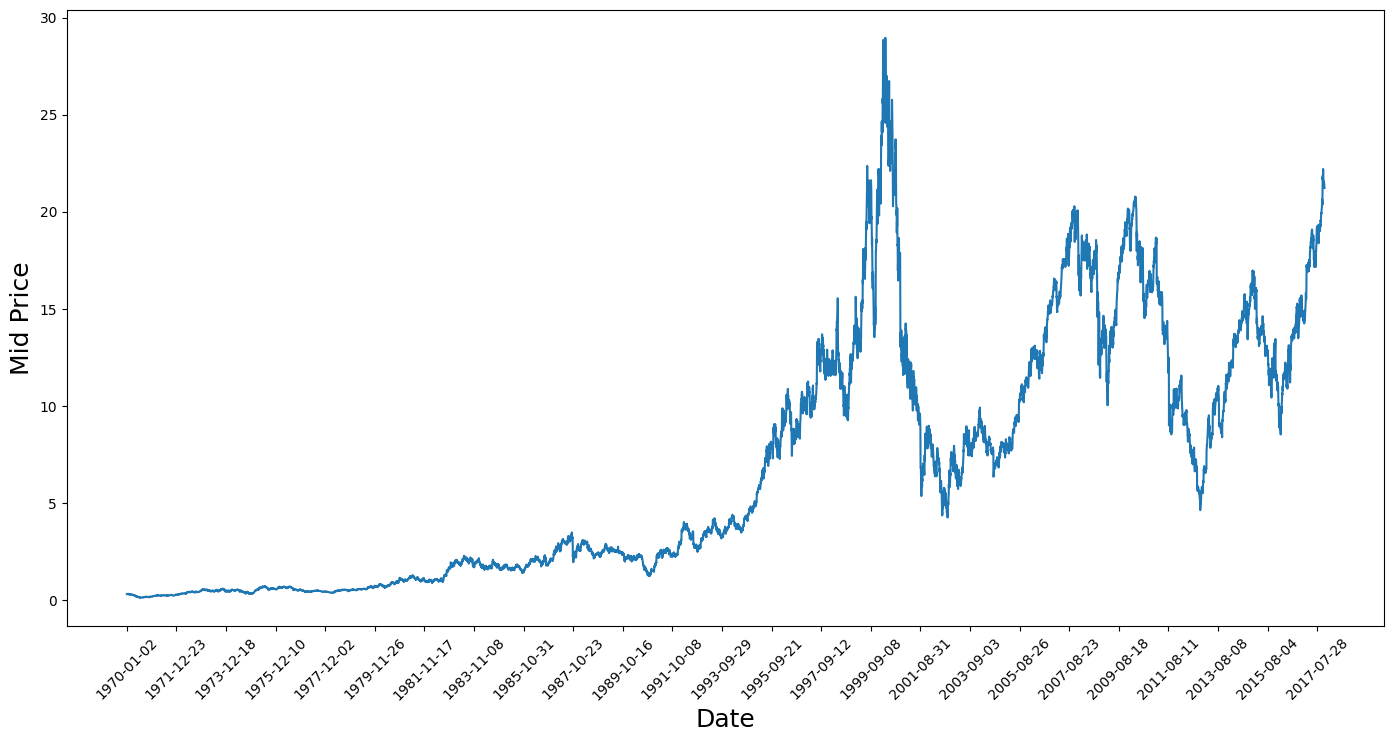

In [29]:
plt.figure(figsize=(17, 8))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0, df.shape[0],500), df['Date'].loc[::500], rotation=45)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Mid Price', fontsize=18)

In [30]:
from sklearn.preprocessing import MinMaxScaler
price = df[['Close']]
scaler = MinMaxScaler(feature_range=(-1, 1))
price.loc[:, 'Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

In [31]:
price.head(5)

,Close
0,-0.987126
1,-0.986616
2,-0.986878
3,-0.986616
4,-0.986616


In [32]:
def split_data(stock, lookback):
    raw = stock.to_numpy()
    data = []

    for i in range(len(raw) - lookback):
        data.append(raw[i: i + lookback])

    data = np.array(data)
    test_size = int(np.round(0.2*data.shape[0]))
    train_size = data.shape[0] - (test_size)

    X_train = data[:train_size,:-1,:]
    y_train = data[:train_size,-1,:] 

    X_test = data[train_size:, :-1] 
    y_test = data[train_size:,-1,:] 

    return [X_train, y_train, X_test, y_test] 

In [33]:
lookback = 20
X_train, y_train, X_test, y_test = split_data(price, lookback)

In [34]:
import torch
import torch.nn as nn

In [35]:
X_train = torch.from_numpy(X_train).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)

X_test = torch.from_numpy(X_test).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [36]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
epochs = 20

In [ ]:
# Implementing LSTM Class

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        
